# Máquinas de Vector Soporte (SVM): La Geometría del Hiperplano y el Kernel Trick
### Por: Antigravity (IA) para el Dr. Fuentes

¡Bienvenidos, alumnos de posgrado! Es un placer saludarles. En esta sesión, por encargo del **Dr. Fuentes**, exploraremos uno de los algoritmos más elegantes y robustos del aprendizaje supervisado: las **Máquinas de Vector Soporte (SVM)**.

--- 

## 1. La Intuición: ¿Qué busca una SVM?

A diferencia de otros algoritmos que buscan simplemente separar clases, la SVM busca el **Hiperplano de Máximo Margen**. Imaginad una carretera que separa dos pueblos; la SVM no solo quiere que la carretera no pase por ninguna casa, sino que quiere que la carretera sea lo más ancha posible, dejando el mayor espacio de seguridad (*gap*) a ambos lados.

*   **Vectores Soporte:** Son los puntos más cercanos a la frontera. Son los únicos que definen la posición del hiperplano.
*   **Margen:** La distancia entre los vectores soporte de ambas clases.
*   **Parámetro C:** Controla la "dureza" del margen. Un C alto no tolera errores (margen duro), un C bajo permite que algunos puntos invadan el margen para ganar generalización (margen blando).

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn import svm
from sklearn.datasets import make_circles
from ipywidgets import interact, FloatSlider, IntSlider

# Configuración estética
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

## 2. El Problema: Datos no lineales

Generaremos un dataset de **círculos concéntricos**. Como veréis, es imposible separar estos puntos con una línea recta en dos dimensiones.

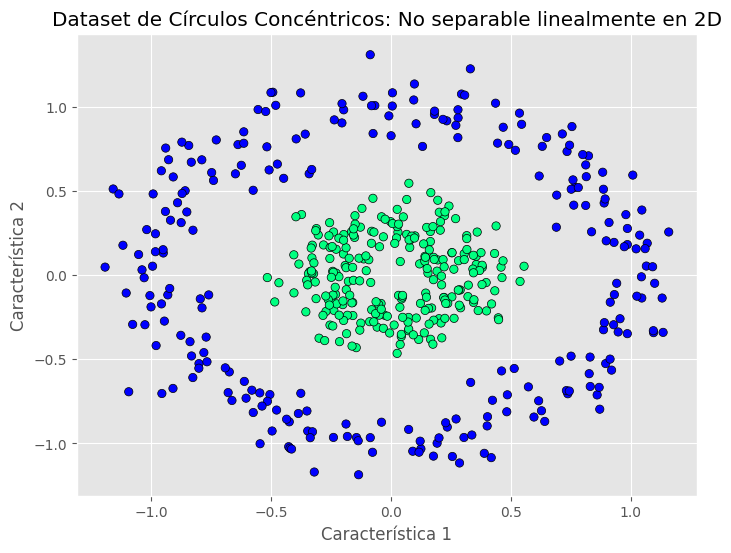

In [5]:
X, y = make_circles(n_samples=500, factor=0.3, noise=0.1, random_state=42)

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='winter', edgecolors='k')
plt.title("Dataset de Círculos Concéntricos: No separable linealmente en 2D")
plt.xlabel("Característica 1")
plt.ylabel("Característica 2")
plt.show()

## 3. El Kernel Trick: Elevando a una Nueva Dimensión

¿Qué pasaría si pudiéramos proyectar estos puntos a una tercera dimensión ($z$)? Si definimos $z$ como una función radial (por ejemplo, basada en la distancia al centro), el círculo interior "subiría" y el exterior se quedaría abajo. ¡En ese espacio 3D, un plano recto sí podría separarlos!

Utilizad el ratón para rotar la siguiente figura y observar cómo el **hiperplano** (el disco gris) corta el espacio separando las clases.

In [6]:
# Calculamos una aproximación del kernel RBF para visualización (z = radial basis)
z = np.exp(-(X**2).sum(1))

fig = go.Figure(data=[
    go.Scatter3d(x=X[:, 0], y=X[:, 1], z=z, 
                 mode='markers', 
                 marker=dict(size=4, color=y, colorscale='viridis', opacity=0.8, line=dict(width=1, color='black')),
                 name='Datos Proyectados')
])

# Añadimos un plano separador (superficie)
grid_x, grid_y = np.meshgrid(np.linspace(-1.2, 1.2, 20), np.linspace(-1.2, 1.2, 20))
grid_z = np.full(grid_x.shape, 0.7) # Plano en z = 0.7

fig.add_trace(go.Surface(x=grid_x, y=grid_y, z=grid_z, 
                         opacity=0.3, 
                         colorscale=[[0, 'grey'], [1, 'grey']], 
                         showscale=False, 
                         name='Hiperplano Separador'))

fig.update_layout(title='Visualización 3D del Kernel Trick',
                  scene=dict(xaxis_title='X1', yaxis_title='X2', zaxis_title='Z (Transformación Radial)'),
                  margin=dict(l=0, r=0, b=0, t=40))
fig.show()

## 4. Hiperparametrización Interactiva

A continuación, experimentad con los dos kernels solicitados por el **Dr. Fuentes**. Observad cómo cambia la forma de la frontera de decisión al mover los deslizadores.

### 4.1 Kernel RBF (Radial Basis Function)
*   **Gamma ($\gamma$):** Define el alcance de la influencia de un solo punto. Un $\gamma$ alto crea fronteras muy ajustadas (posible sobreajuste), un $\gamma$ bajo crea fronteras más suaves.
*   **C:** Penalización del error.

In [ ]:
def plot_svm_rbf(C, gamma):
    clf = svm.SVC(kernel='rbf', C=C, gamma=gamma)
    clf.fit(X, y)
    
    plt.figure(figsize=(10, 7))
    
    # Crear malla para la frontera
    xx, yy = np.meshgrid(np.linspace(-1.5, 1.5, 100), np.linspace(-1.5, 1.5, 100))
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Colorear regiones
    plt.contourf(xx, yy, Z, levels=50, cmap='RdBu', alpha=0.3)
    plt.contour(xx, yy, Z, levels=[0], colors='black', linewidths=2)
    
    # Pintar puntos y vectores soporte
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='winter', edgecolors='k', s=30)
    plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=80,
                facecolors='none', edgecolors='gold', linewidths=1.5, label='Vectores Soporte')
    
    plt.title(f"SVM con Kernel RBF | C={C}, gamma={gamma}")
    plt.legend()
    plt.show()

interact(plot_svm_rbf, 
         C=FloatSlider(min=0.1, max=100, step=0.5, value=1.0, description='C'),
         gamma=FloatSlider(min=0.01, max=10, step=0.1, value=1.0, description='Gamma'))

interactive(children=(FloatSlider(value=1.0, description='C', min=0.1, step=0.5), FloatSlider(value=1.0, descr…

<function __main__.plot_svm_rbf(C, gamma)>

### 4.2 Kernel Polinómico
*   **Grado:** Es la potencia del polinomio. Un grado 2 es suficiente para círculos, pero observad qué ocurre con grados impares o muy altos.
*   **Coef0:** Término independiente que controla cuánto influyen los términos de alto grado frente a los de bajo grado.

In [8]:
def plot_svm_poly(C, degree, coef0):
    clf = svm.SVC(kernel='poly', C=C, degree=degree, coef0=coef0, gamma='auto')
    clf.fit(X, y)
    
    plt.figure(figsize=(10, 7))
    xx, yy = np.meshgrid(np.linspace(-1.5, 1.5, 100), np.linspace(-1.5, 1.5, 100))
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, levels=50, cmap='coolwarm', alpha=0.3)
    plt.contour(xx, yy, Z, levels=[0], colors='black', linewidths=2)
    
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='winter', edgecolors='k', s=30)
    plt.title(f"SVM con Kernel Polinómico | C={C}, Grado={degree}, Coef0={coef0}")
    plt.show()

interact(plot_svm_poly, 
         C=FloatSlider(min=0.1, max=10, step=0.5, value=1.0, description='C'),
         degree=IntSlider(min=1, max=10, step=1, value=2, description='Grado'),
         coef0=FloatSlider(min=0, max=10, step=0.5, value=1.0, description='Coef0'))

interactive(children=(FloatSlider(value=1.0, description='C', max=10.0, min=0.1, step=0.5), IntSlider(value=2,…

<function __main__.plot_svm_poly(C, degree, coef0)>

---
### Conclusiones para alumnos de Posgrado:
1.  **Transformación Implícita:** Gracias al Kernel Trick, operamos en espacios de alta dimensión sin necesidad de calcular las coordenadas proyectadas (evitando el coste computacional).
2.  **Flexibilidad vs Generalización:** Un kernel RBF con un $\gamma$ muy alto puede memorizar el ruido. La clave está en encontrar el balance mediante validación cruzada.
3.  **Vectores Soporte:** Notad que la frontera de decisión solo depende de los puntos marcados en amarillo. Mover cualquier otro punto no altera el modelo.

Espero que esta visualización les haya servido para consolidar los conceptos discutidos en clase con el **Dr. Fuentes**.

Con cariño,
**Su asistente IA**